## 03 Feature Engineering (Exploration & Validation)

The FIRST cell below executes the canonical pipeline in `scripts/feature_engineering.py` so this notebook never hand-implements feature logic.

Use this notebook to:
1. Re-run the pipeline (Cell 1) when logic changes upstream.
2. Inspect engineered dataset structure & metadata.
3. Visualize cancellation relationships.
4. Validate integrity vs artifacts (contract, mappings, schema).

If you need to change feature definitions:
- Edit `scripts/feature_engineering.py`
- Re-run Cell 1
- Re-run downstream analysis cells

Avoid manual mutation of `df` here to guarantee reproducibility and alignment with the API inference path.


In [4]:
# Run canonical feature engineering pipeline (first cell)
# Re-generates engineered dataset & artifacts deterministically.
import subprocess, sys, pathlib, os

# Derive project root (parent of this notebooks directory)
PROJECT_ROOT = pathlib.Path('..').resolve()
SCRIPT_PATH = PROJECT_ROOT / 'scripts' / 'feature_engineering.py'
assert SCRIPT_PATH.exists(), f"Missing pipeline script at {SCRIPT_PATH}"

print('Executing feature engineering pipeline...')
print('Using project root:', PROJECT_ROOT)
print('Script path:', SCRIPT_PATH)

proc = subprocess.run([sys.executable, str(SCRIPT_PATH)], capture_output=True, text=True, cwd=str(PROJECT_ROOT))
print(proc.stdout)
if proc.returncode != 0:
    print(proc.stderr)
    raise SystemExit(f"Pipeline failed with exit code {proc.returncode}")
print('✅ Feature engineering pipeline finished successfully.')

Executing feature engineering pipeline...
Using project root: /Users/jam/serendip-travel/hotel-cancellation-prediction
Script path: /Users/jam/serendip-travel/hotel-cancellation-prediction/scripts/feature_engineering.py
✅ Feature engineering (simplified) complete
Final shape: (119390, 46)
 Saved: data/processed/hotel_booking_features.csv

 Mean Target Encoded Columns (corr):
 - hotel → hotel_target_encoded (corr=0.1363)
 - market_segment → market_segment_target_encoded (corr=0.2666)
 - distribution_channel → distribution_channel_target_encoded (corr=0.1768)
 - reserved_room_type → reserved_room_type_target_encoded (corr=0.0724)
 - customer_type → customer_type_target_encoded (corr=0.1363)

✅ Feature engineering pipeline finished successfully.
✅ Feature engineering (simplified) complete
Final shape: (119390, 46)
 Saved: data/processed/hotel_booking_features.csv

 Mean Target Encoded Columns (corr):
 - hotel → hotel_target_encoded (corr=0.1363)
 - market_segment → market_segment_target_e

In [13]:
# 2. Load engineered dataset & basic summary (metadata-aware)
import pandas as pd, json, pathlib
DATA_DIR = pathlib.Path('../data/processed')
FEATURE_FILE = DATA_DIR / 'hotel_booking_features.csv'
META_FILE = DATA_DIR / 'hotel_booking_features_metadata.json'
assert FEATURE_FILE.exists(), f"Engineered dataset not found: {FEATURE_FILE}"

# Load dataset
df = pd.read_csv(FEATURE_FILE)
print('Engineered shape:', df.shape)
print('Columns (sample):', df.columns[:14].tolist(), '...')

with open(META_FILE) as f:
    meta = json.load(f)
print('\nMetadata keys:', list(meta.keys()))
print('Final shape from metadata:', meta.get('final_shape'))
print('Mean target encoded features:', list(meta.get('mean_target_encoding', {}).keys()))

target = 'is_canceled'
print('Target cancellation rate:', round(df[target].mean(), 4))

eng_cols_numeric = [c for c in df.columns if c.endswith('_target_encoded') or c in ['total_stay_duration','is_family','is_peak_season','is_summer_peak','is_holiday_season']]
correlations = {c: round(df[c].corr(df[target]), 4) for c in eng_cols_numeric if df[c].dtype != 'O'}
print('\nSample correlations:', correlations)

Engineered shape: (119390, 46)
Columns (sample): ['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country'] ...

Metadata keys: ['started', 'core_features_added', 'temporal_features_added', 'mean_target_encoding', 'final_shape', 'completed']
Final shape from metadata: [119390, 46]
Mean target encoded features: ['hotel', 'market_segment', 'distribution_channel', 'reserved_room_type', 'customer_type']
Target cancellation rate: 0.3704

Sample correlations: {'total_stay_duration': np.float64(0.019), 'is_family': np.float64(-0.0126), 'is_peak_season': np.float64(-0.0008), 'is_summer_peak': np.float64(0.0002), 'is_holiday_season': np.float64(0.0288), 'hotel_target_encoded': np.float64(0.1363), 'market_segment_target_encoded': np.float64(0.2666), 'distribution_channel_target_encoded': np.float64(0.1768), 'reserved_

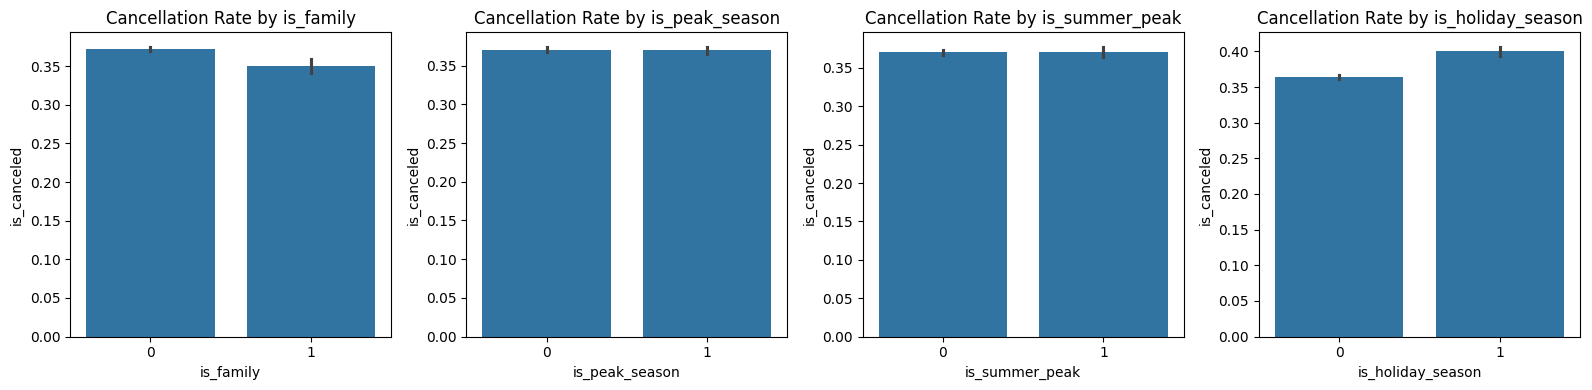

Plotted cancellation rates for flags: ['is_family', 'is_peak_season', 'is_summer_peak', 'is_holiday_season']


In [14]:
# 3. Visualization: cancellation rate by key engineered flags
import matplotlib.pyplot as plt
import seaborn as sns

flag_cols = [c for c in ['is_family','is_peak_season','is_summer_peak','is_holiday_season'] if c in df.columns]
if not flag_cols:
    print('No expected flag columns present.')
else:
    fig, axes = plt.subplots(1, len(flag_cols), figsize=(4*len(flag_cols),4))
    if len(flag_cols) == 1:
        axes = [axes]
    for ax, col in zip(axes, flag_cols):
        sns.barplot(x=col, y=df[target], data=df, estimator=lambda x: sum(x)/len(x), ax=ax)
        ax.set_title(f'Cancellation Rate by {col}')
    plt.tight_layout()
    plt.show()
    print('Plotted cancellation rates for flags:', flag_cols)

/var/folders/0p/29y5gpjs09jd6rt_9jltqj7w0000gn/T/ipykernel_31686/1812869403.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_series.values, y=corr_series.index, palette='viridis')


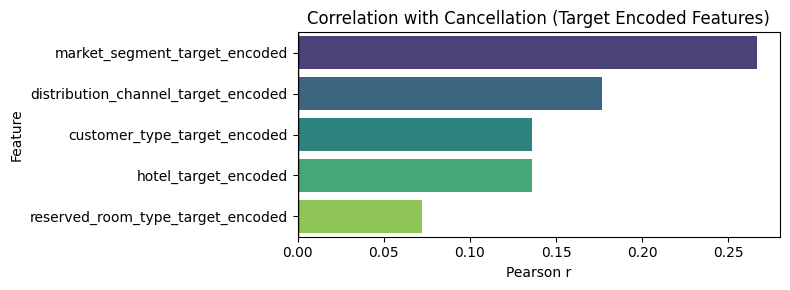

market_segment_target_encoded          0.266581
distribution_channel_target_encoded    0.176845
customer_type_target_encoded           0.136296
hotel_target_encoded                   0.136292
reserved_room_type_target_encoded      0.072413
dtype: float64


In [15]:
# 4. Visualization: target-encoded feature correlations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

te_cols = [c for c in df.columns if c.endswith('_target_encoded')]
if te_cols:
    corr_series = pd.Series({c: df[c].corr(df[target]) for c in te_cols}).sort_values(key=lambda s: s.abs(), ascending=False)
    plt.figure(figsize=(8, max(3, 0.4*len(corr_series))))
    sns.barplot(x=corr_series.values, y=corr_series.index, palette='viridis')
    plt.title('Correlation with Cancellation (Target Encoded Features)')
    plt.xlabel('Pearson r')
    plt.ylabel('Feature')
    plt.axvline(0, color='black', linewidth=1)
    plt.tight_layout()
    plt.show()
    print(corr_series.head(10))
else:
    print('No target encoded columns detected.')